In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.1 MB/s eta 0:00:00


In [ ]:
!tar -xvf "/content/drive/MyDrive/ip102/ip102_v1.1.tar" -C "/content/drive/MyDrive/ip102/"

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
#drive.flush_and_unmount()

In [ ]:
import numpy as np
import pandas as pd
import os
import random
from tqdm import tqdm
from textwrap import wrap

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import timm

In [ ]:
f = open('/content/drive/MyDrive/ip102/classes.txt')
label = []
name = []
for line in f.readlines():
    label.append(int(line.split()[0]))
    name.append(' '.join(line.split()[1:]))
classes = pd.DataFrame([label, name]).T
classes.columns = ['label','name']

# Subtract 1 from each label in the DataFrame
classes['label'] = classes['label'].apply(lambda x: x - 1)

classes

label                        name
0        0            rice leaf roller
1        1       rice leaf caterpillar
2        2           paddy stem maggot
3        3          asiatic rice borer
4        4           yellow rice borer
..     ...                         ...
97      97        Chlumetia transversa
98      98  Mango flat beak leafhopper
99      99  Rhytidodera bowrinii white
100    100       Sternochetus frigidus
101    101                Cicadellidae

[102 rows x 2 columns]

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/ip102/ip102_v1.1/train.txt',sep=' ',header=None, engine='python')
train_df.columns = ['image_path','label']

test_df = pd.read_csv('/content/drive/MyDrive/ip102/ip102_v1.1/test.txt',sep=' ',header=None, engine='python')
test_df.columns = ['image_path','label']

val_df = pd.read_csv('/content/drive/MyDrive/ip102/ip102_v1.1/val.txt',sep=' ',header=None, engine='python')
val_df.columns = ['image_path','label']

train_df.head()

image_path  label
0  00002.jpg      0
1  00003.jpg      0
2  00005.jpg      0
3  00006.jpg      0
4  00008.jpg      0

In [ ]:
import shutil

# Define the source and destination directories
source_dir = "/content/drive/MyDrive/ip102/ip102_v1.1/images"
destination_dir = "/content/drive/MyDrive/ip102/ip102_v1.1/images"

# Function to move images to their respective directories
def move_images(df, set_name):
    destination_set_dir = os.path.join(destination_dir, set_name)
    os.makedirs(destination_set_dir, exist_ok=True)

    for _, row in df.iterrows():
        image_filename = row['image_path']
        source_path = os.path.join(source_dir, image_filename)
        destination_path = os.path.join(destination_set_dir, image_filename)

        shutil.move(source_path, destination_path)
        print(f"Moved {image_filename} to {destination_path}")

# Call the function for each dataframe
move_images(train_df, "train")
move_images(test_df, "test")
move_images(val_df, "val")

In [ ]:
# Define the source and destination base directories
source_base_dirs = ["/content/drive/MyDrive/ip102/ip102_v1.1/images/train", "/content/drive/MyDrive/ip102/ip102_v1.1/images/test", "/content/drive/MyDrive/ip102/ip102_v1.1/images/val"]
destination_base_dir_train = "/content/drive/MyDrive/ip102/ip102_v1.1/images/train"
destination_base_dir_test = "/content/drive/MyDrive/ip102/ip102_v1.1/images/test"
destination_base_dir_val = "/content/drive/MyDrive/ip102/ip102_v1.1/images/val"

# Function to move images to their respective label directories
def move_images_to_label_dirs(df, source_base_dir, destination_base_dir):
    for _, row in df.iterrows():
        image_filename = row['image_path']
        label = row['label']
        source_path = os.path.join(source_base_dir, image_filename)
        destination_path = os.path.join(destination_base_dir, str(label), image_filename)
        os.makedirs(os.path.join(destination_base_dir, str(label)), exist_ok=True)
        shutil.move(source_path, destination_path)
        print(f"Moved {image_filename} to {destination_path}")

# Call the function for each dataframe with the corresponding source directory
move_images_to_label_dirs(train_df, source_base_dirs[0], destination_base_dir_train)
move_images_to_label_dirs(test_df, source_base_dirs[1], destination_base_dir_test)
move_images_to_label_dirs(val_df, source_base_dirs[2], destination_base_dir_val)

In [ ]:
!zip -r "/content/ip102_classified.zip" "/content/drive/MyDrive/ip102/ip102_v1.1"

In [ ]:
from google.colab import files
files.download("/content/ip102_classified.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/ip102/ip102_v1.1/images/train'
TEST_DIR = '/content/drive/MyDrive/ip102/ip102_v1.1/images/test'
VAL_DIR = '/content/drive/MyDrive/ip102/ip102_v1.1/images/val'

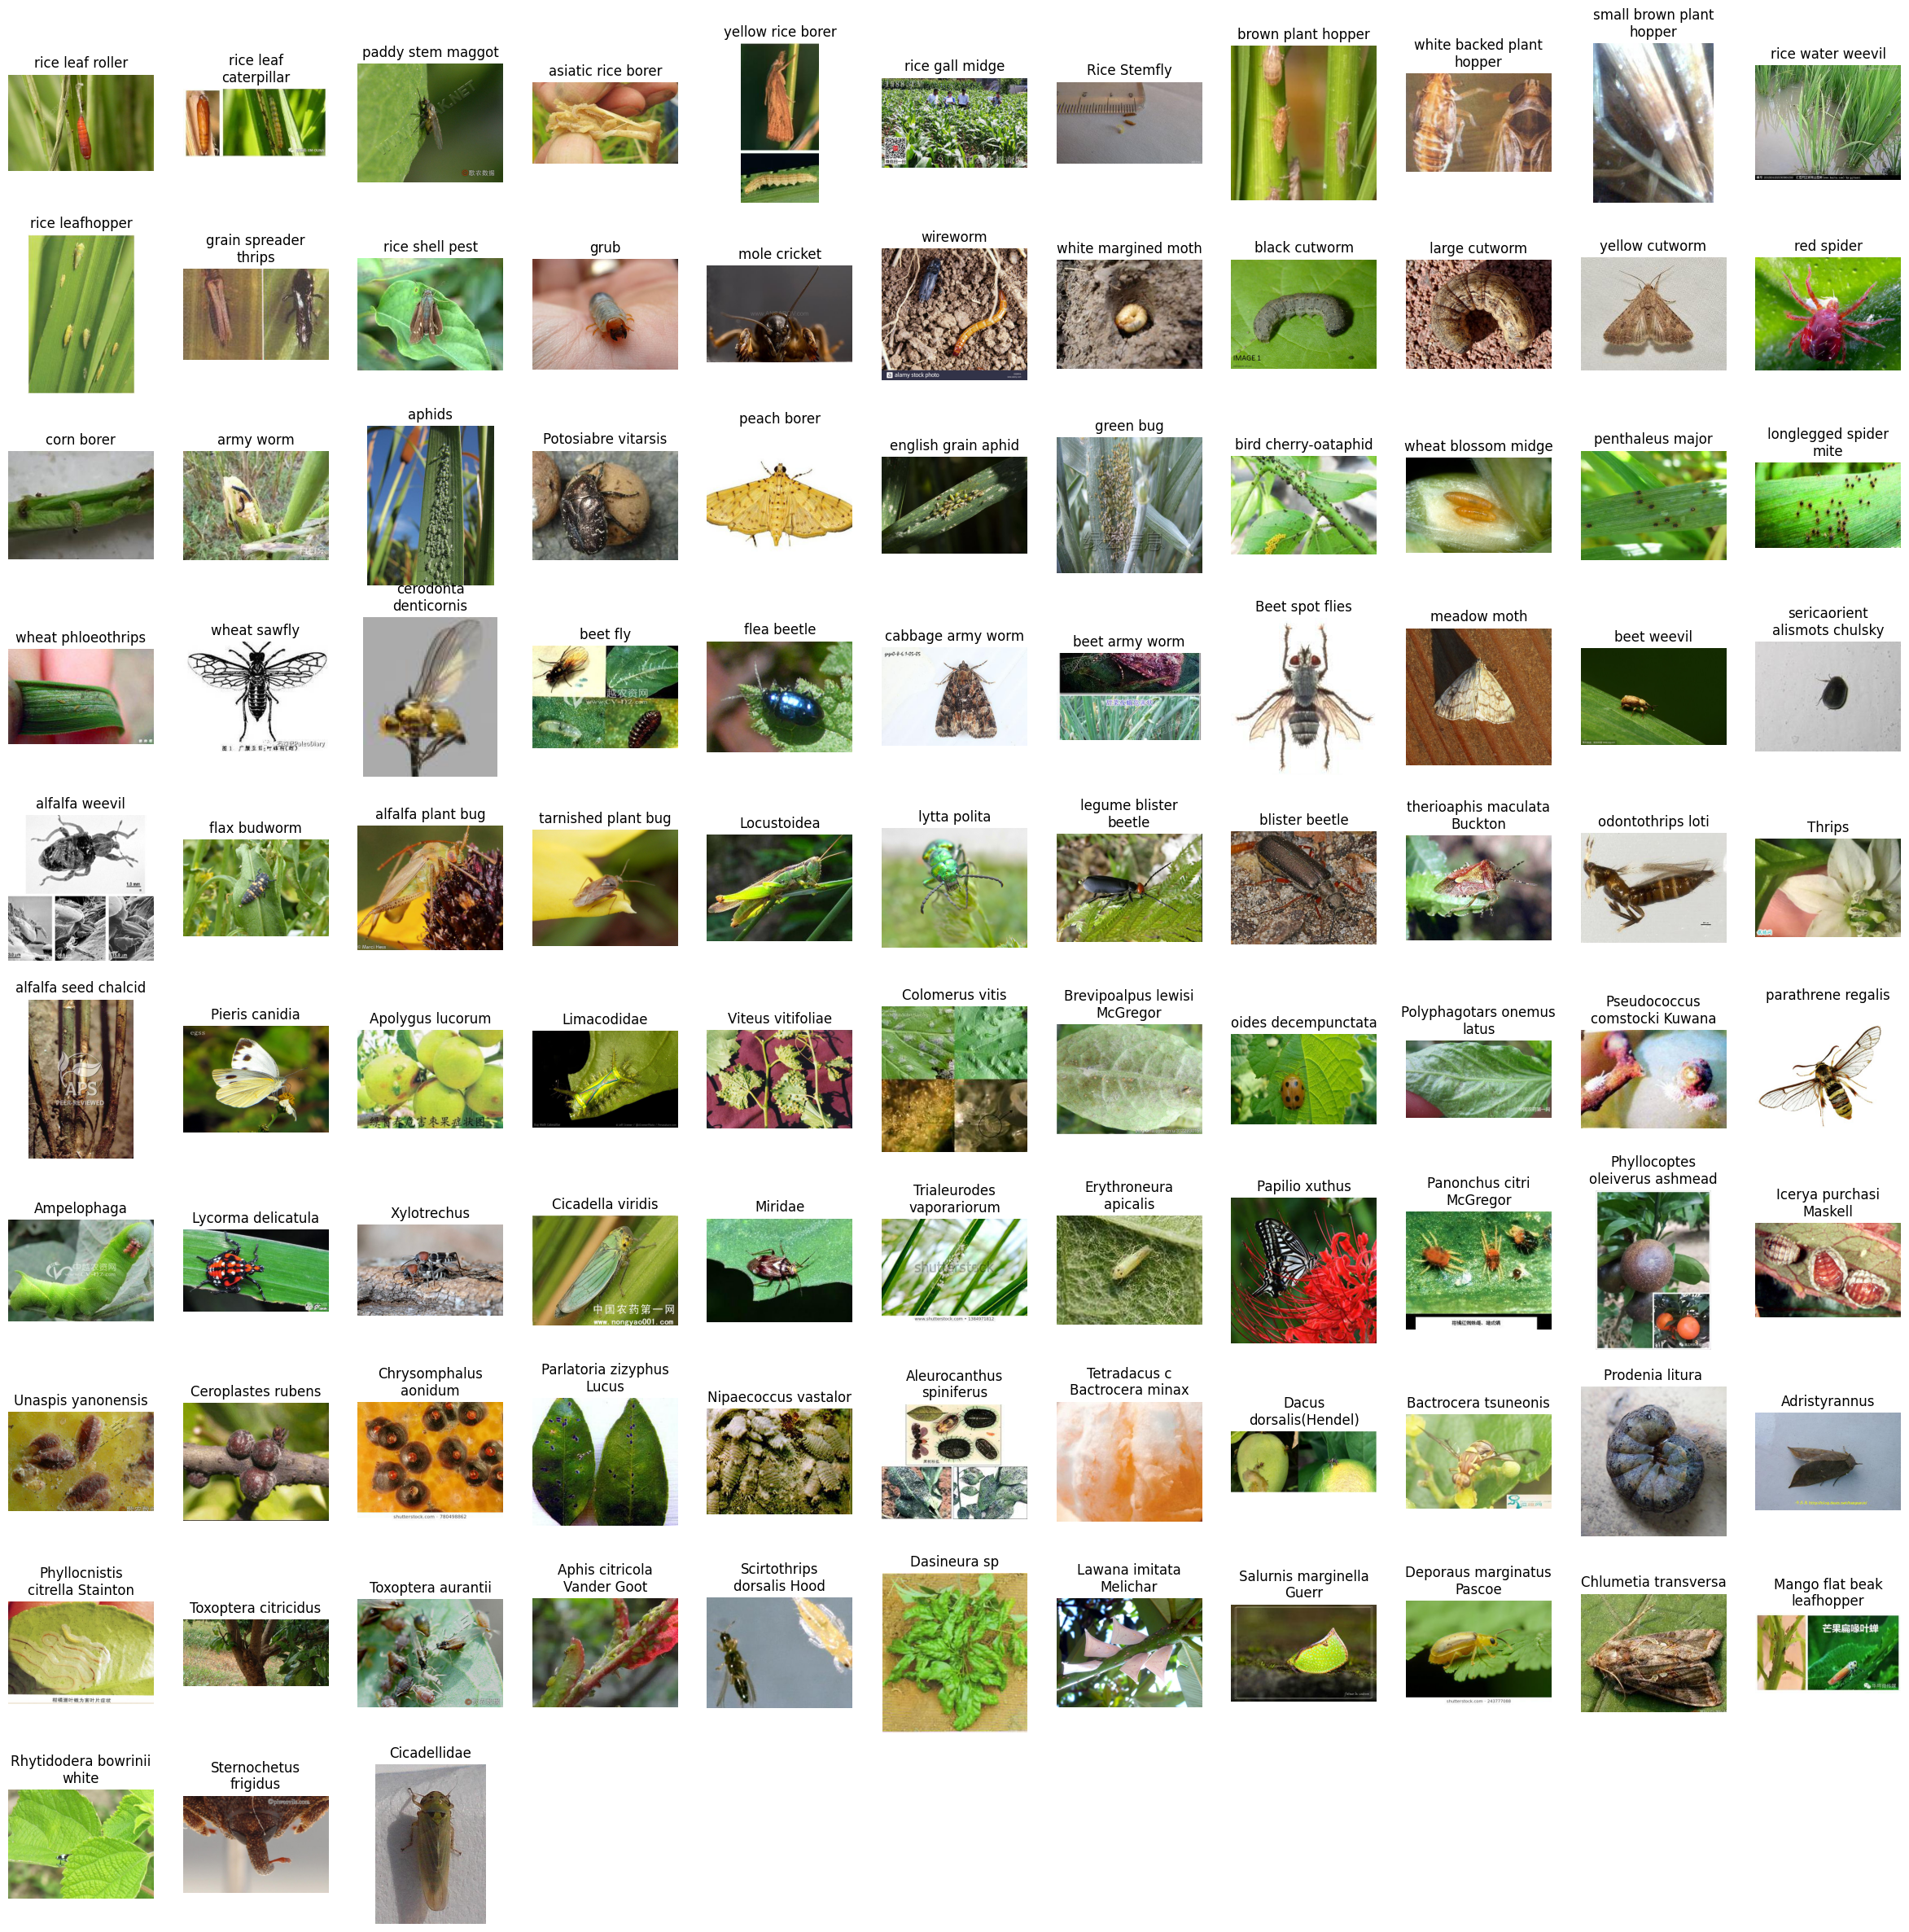

In [ ]:
fig, axs = plt.subplots(10,11,figsize=(30,30))
images = []
for i in classes.label:
    random_img = random.choice(train_df[train_df.label==i].image_path.values)
    label = classes.name[i]
    img = plt.imread(os.path.join(TRAIN_DIR,str(i),random_img))
    images.append(img)

[ax.imshow(image) for image,ax in zip(images,axs.ravel())]
[ax.set_title("\n".join(wrap(label,20))) for label,ax in zip(list(classes.name),axs.ravel())]
[ax.set_axis_off() for ax in axs.ravel()]
plt.show()

In [ ]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import numpy as np
import cv2


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from skimage.feature import hog
import cv2
import numpy as np

# Path to the training and validation directories
train_dir = '/content/drive/MyDrive/ip102/ip102_v1.1/images/train'
test_dir = '/content/drive/MyDrive/ip102/ip102_v1.1/images/test'

def extract_hog_features(img):
    img = cv2.resize(img, (64, 64))
    features = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1))
    return features

def feature_extractor(directory):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(directory, target_size=(64, 64), batch_size=90, class_mode='sparse', color_mode='grayscale')

    data_list = []
    labels_list = []

     # Add tqdm progress bar
    for inputs_batch, labels_batch in tqdm(generator):
        features_batch = np.array([extract_hog_features(img) for img in inputs_batch])
        data_list.extend(features_batch)
        labels_list.extend(labels_batch)
        if len(data_list) >= generator.samples:
            break

    return np.array(data_list), np.array(labels_list)



In [ ]:
X_train, y_train = feature_extractor(train_dir)

Found 45095 images belonging to 102 classes.


100%|█████████▉| 501/502 [3:06:14<00:22, 22.30s/it]


In [ ]:
np.save('/content/drive/MyDrive/ip102/X_train.npy', X_train)
np.save('/content/drive/MyDrive/ip102/y_train.npy', y_train)

In [ ]:
!zip -r "/content/X_train.zip" "/content/drive/MyDrive/ip102/X_train.npy"
!zip -r "/content/y_train.zip" "/content/drive/MyDrive/ip102/y_train.npy"

  adding: content/drive/MyDrive/ip102/X_train.npy (deflated 61%)
  adding: content/drive/MyDrive/ip102/y_train.npy (deflated 69%)


In [ ]:
from google.colab import files
files.download("/content/X_train.zip")
files.download("/content/y_train.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X_test, y_test = feature_extractor(test_dir)

Found 22619 images belonging to 102 classes.


100%|█████████▉| 251/252 [44:40<00:10, 10.68s/it]


In [ ]:
np.save('/content/drive/MyDrive/ip102/X_test.npy', X_test)
np.save('/content/drive/MyDrive/ip102/y_test.npy', y_test)

In [ ]:
!zip -r "/content/X_test.zip" "/content/drive/MyDrive/ip102/X_test.npy"
!zip -r "/content/y_test.zip" "/content/drive/MyDrive/ip102/y_test.npy"

  adding: content/drive/MyDrive/ip102/X_test.npy (deflated 61%)
  adding: content/drive/MyDrive/ip102/y_test.npy (deflated 69%)


In [ ]:
files.download("/content/X_test.zip")
files.download("/content/y_test.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X_train = np.load('/content/drive/MyDrive/ip102/X_train.npy')
y_train = np.load('/content/drive/MyDrive/ip102/y_train.npy')
X_test = np.load('/content/drive/MyDrive/ip102/X_test.npy')
y_test = np.load('/content/drive/MyDrive/ip102/y_test.npy')

In [ ]:
clf = RandomForestClassifier(n_estimators=700, max_depth=50, min_samples_split=2, min_samples_leaf=1, max_features='log2', random_state=77)

# Train the classifier
y_train = y_train.astype(int)
clf.fit(X_train, y_train)

# Predict the labels of the testing set
y_test = y_test.astype(int)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.51      0.37      0.43       335
           1       0.78      0.12      0.21       147
           2       1.00      0.14      0.25       257
           3       0.57      0.06      0.11       138
           4       0.16      0.62      0.25      1723
           5       0.71      0.04      0.08       122
           6       1.00      0.13      0.24        52
           7       1.00      0.04      0.08       123
           8       0.30      0.06      0.10       258
           9       0.20      0.18      0.19       495
          10       0.81      0.06      0.12       267
          11       0.50      0.04      0.08        45
          12       0.28      0.04      0.06       257
          13       0.43      0.02      0.04       148
          14       1.00      0.04      0.07        79
          15       0.67      0.03      0.05       144
          16       0.00      0.00      0.00       159
          17       0.39    

In [ ]:
# get classification report in dict format
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

# create DataFrame
df = pd.DataFrame(report_dict).transpose()

# sort by f1-score (high to low)
df_sorted = df.sort_values(by='f1-score', ascending=False)

print(df_sorted.to_string(index=True))

              precision    recall  f1-score       support
26             0.888889  0.328767  0.480000    146.000000
0              0.514644  0.367164  0.428571    335.000000
47             0.911765  0.203947  0.333333    152.000000
25             0.584000  0.231013  0.331066    316.000000
36             0.529412  0.236842  0.327273    152.000000
76             1.000000  0.188940  0.317829    217.000000
77             1.000000  0.182540  0.308725    126.000000
80             0.386076  0.227612  0.286385    268.000000
83             0.945946  0.168269  0.285714    208.000000
30             0.944444  0.166667  0.283333    102.000000
96             1.000000  0.160920  0.277228    174.000000
4              0.155761  0.624492  0.249334   1723.000000
2              1.000000  0.140078  0.245734    257.000000
65             0.750000  0.143478  0.240876    230.000000
68             0.805970  0.140625  0.239468    384.000000
6              1.000000  0.134615  0.237288     52.000000
66            

In [ ]:
# Get per-class report and aggregate report
per_class_report = df_sorted.loc[df_sorted.index.str.isdigit()]
aggregate_report = df_sorted.loc[df_sorted.index.str.isdigit() == False]

# Print them separately
print(per_class_report.to_string(index=True))
print(aggregate_report.to_string(index=True))

     precision    recall  f1-score  support
26    0.888889  0.328767  0.480000    146.0
0     0.514644  0.367164  0.428571    335.0
47    0.911765  0.203947  0.333333    152.0
25    0.584000  0.231013  0.331066    316.0
36    0.529412  0.236842  0.327273    152.0
76    1.000000  0.188940  0.317829    217.0
77    1.000000  0.182540  0.308725    126.0
80    0.386076  0.227612  0.286385    268.0
83    0.945946  0.168269  0.285714    208.0
30    0.944444  0.166667  0.283333    102.0
96    1.000000  0.160920  0.277228    174.0
4     0.155761  0.624492  0.249334   1723.0
2     1.000000  0.140078  0.245734    257.0
65    0.750000  0.143478  0.240876    230.0
68    0.805970  0.140625  0.239468    384.0
6     1.000000  0.134615  0.237288     52.0
66    0.147227  0.564617  0.233554   1594.0
84    0.882353  0.128205  0.223881    117.0
31    0.500000  0.142857  0.222222     42.0
1     0.782609  0.122449  0.211765    147.0
17    0.387978  0.139216  0.204906    510.0
35    0.708861  0.116183  0.1996

In [ ]:
from sklearn.model_selection import GridSearchCV

# define the parameter values to be searched
k_range = list(range(1, 31))

# create a parameter grid: map the parameter names to the values to be searched
param_grid = dict(n_neighbors=k_range)

# instantiate the grid
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='accuracy')

# fit the grid with data
grid.fit(X_train,y_train)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.1997120712996279
{'n_neighbors': 1}


In [ ]:
# define the parameter values to be searched
k_range_2 = list(range(31, 51))

# create a parameter grid: map the parameter names to the values to be searched
param_grid_2 = dict(n_neighbors=k_range_2)

# instantiate the grid
grid_2 = GridSearchCV(KNeighborsClassifier(), param_grid_2, cv=10, scoring='accuracy')

# fit the grid with data
grid_2.fit(X_train,y_train)

# examine the best model
print(grid_2.best_score_)
print(grid_2.best_params_)

0.1233174252628028
{'n_neighbors': 31}


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier(n_neighbors=1)

# Train the classifier
y_train = y_train.astype(int)
knn.fit(X_train,y_train)

# Predict the labels of the testing set
y_test = y_test.astype(int)
y_pred_knn=knn.predict(X_test)
y_pred_knn

#accuracy_score(y_pred_knn,y_test)
print(classification_report(y_pred_knn,y_test))

              precision    recall  f1-score   support

           0       0.45      0.38      0.41       404
           1       0.25      0.28      0.27       131
           2       0.39      0.41      0.40       242
           3       0.25      0.38      0.30        93
           4       0.18      0.23      0.20      1313
           5       0.16      0.15      0.16       135
           6       0.25      0.29      0.27        45
           7       0.24      0.23      0.24       129
           8       0.13      0.10      0.12       324
           9       0.25      0.17      0.20       719
          10       0.16      0.13      0.14       348
          11       0.09      0.05      0.07        74
          12       0.14      0.08      0.10       435
          13       0.07      0.05      0.06       214
          14       0.16      0.17      0.17        78
          15       0.15      0.09      0.11       238
          16       0.06      0.03      0.04       273
          17       0.25    

In [ ]:
# get classification report in dict format
report_dict_2 = classification_report(y_test, y_pred_knn, output_dict=True, zero_division=0)

# create DataFrame
df_2 = pd.DataFrame(report_dict_2).transpose()

# sort by f1-score (high to low)
df_sorted_2 = df_2.sort_values(by='f1-score', ascending=False)

# Get per-class report and aggregate report
per_class_report_2 = df_sorted_2.loc[df_sorted_2.index.str.isdigit()]
aggregate_report_2 = df_sorted_2.loc[df_sorted_2.index.str.isdigit() == False]

# Print them separately
print(per_class_report_2.to_string(index=True))
print(aggregate_report_2.to_string(index=True))

     precision    recall  f1-score  support
26    0.582278  0.630137  0.605263    146.0
96    0.464968  0.419540  0.441088    174.0
76    0.427861  0.396313  0.411483    217.0
0     0.376238  0.453731  0.411367    335.0
30    0.500000  0.343137  0.406977    102.0
2     0.413223  0.389105  0.400802    257.0
36    0.398601  0.375000  0.386441    152.0
97    0.457143  0.326531  0.380952    147.0
84    0.368000  0.393162  0.380165    117.0
47    0.371069  0.388158  0.379421    152.0
21    0.356808  0.365385  0.361045    208.0
66    0.332765  0.367629  0.349329   1594.0
83    0.307393  0.379808  0.339785    208.0
48    0.334123  0.333333  0.333728    423.0
20    0.297030  0.352941  0.322581    170.0
99    0.315789  0.326087  0.320856     92.0
92    0.323077  0.308824  0.315789     68.0
68    0.348243  0.283854  0.312769    384.0
25    0.290055  0.332278  0.309735    316.0
64    0.302326  0.309524  0.305882     42.0
58    0.278195  0.333333  0.303279    111.0
3     0.376344  0.253623  0.3030

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb=GaussianNB(var_smoothing=1e-9)

# Train the classifier
y_train = y_train.astype(int)
nb.fit(X_train,y_train)

# Predict the labels of the testing set
y_test = y_test.astype(int)
y_pred_nb=nb.predict(X_test)

print(classification_report(y_pred_nb,y_test))

              precision    recall  f1-score   support

           0       0.06      0.11      0.08       194
           1       0.02      0.05      0.03        55
           2       0.00      0.07      0.01        14
           3       0.07      0.04      0.05       217
           4       0.03      0.20      0.05       279
           5       0.05      0.05      0.05       113
           6       0.04      0.03      0.03        79
           7       0.04      0.11      0.06        46
           8       0.01      0.02      0.01       111
           9       0.02      0.04      0.02       182
          10       0.01      0.03      0.01        62
          11       0.36      0.01      0.01      2498
          12       0.00      0.00      0.00        37
          13       0.01      0.01      0.01       154
          14       0.00      0.00      0.00        22
          15       0.00      0.00      0.00        64
          16       0.01      0.02      0.01        45
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# get classification report in dict format
report_dict_3 = classification_report(y_test, y_pred_nb, output_dict=True, zero_division=0)

# create DataFrame
df_3 = pd.DataFrame(report_dict_3).transpose()

# sort by f1-score (high to low)
df_sorted_3 = df_3.sort_values(by='f1-score', ascending=False)

# Get per-class report and aggregate report
per_class_report_3 = df_sorted_3.loc[df_sorted_3.index.str.isdigit()]
aggregate_report_3 = df_sorted_3.loc[df_sorted_3.index.str.isdigit() == False]

# Print them separately
print(per_class_report_3.to_string(index=True))
print(aggregate_report_3.to_string(index=True))

     precision    recall  f1-score  support
36    0.063752  0.230263  0.099857    152.0
56    0.071156  0.133017  0.092715    421.0
0     0.108247  0.062687  0.079395    335.0
26    0.048561  0.184932  0.076923    146.0
65    0.060847  0.100000  0.075658    230.0
7     0.108696  0.040650  0.059172    123.0
84    0.142857  0.034188  0.055172    117.0
4     0.197133  0.031921  0.054945   1723.0
5     0.053097  0.049180  0.051064    122.0
3     0.041475  0.065217  0.050704    138.0
69    0.046429  0.051793  0.048964    251.0
96    0.142857  0.028736  0.047847    174.0
97    0.029617  0.115646  0.047157    147.0
99    0.050000  0.043478  0.046512     92.0
38    0.032432  0.074074  0.045113     81.0
86    0.047619  0.039216  0.043011     51.0
35    0.053957  0.031120  0.039474    482.0
70    0.197452  0.020328  0.036861   1525.0
88    0.111111  0.021277  0.035714     94.0
80    0.056000  0.026119  0.035623    268.0
68    0.053763  0.026042  0.035088    384.0
29    0.027586  0.045455  0.0343

Found 22619 images belonging to 102 classes.


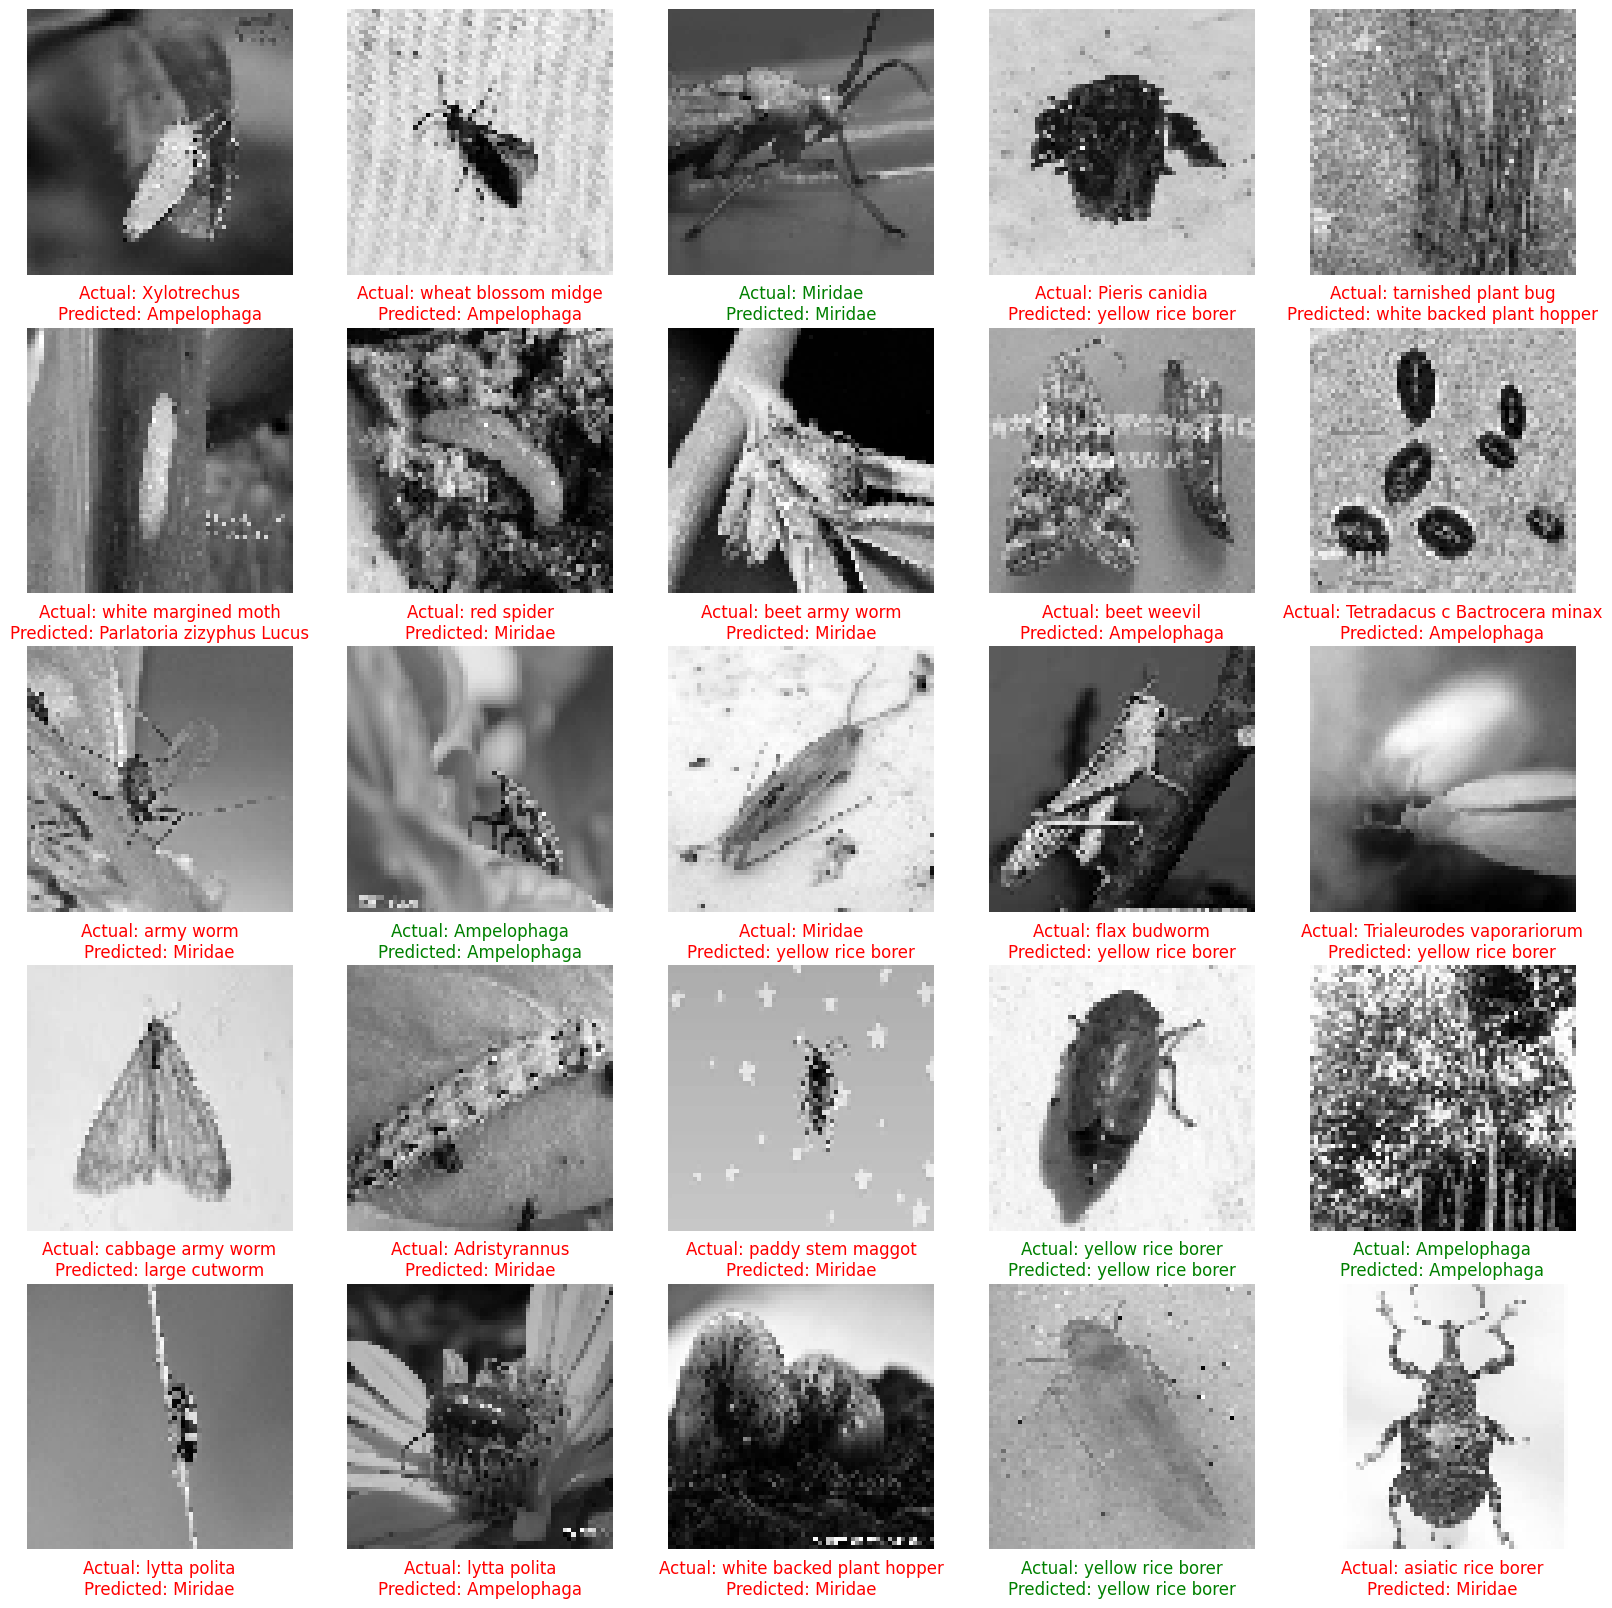

In [ ]:
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

np.random.seed(77)
label_to_name = dict(zip(classes['label'], classes['name']))
num_samples = 25
# Create a new generator just for capturing a few test images
datagen_test = ImageDataGenerator(rescale=1./255)
test_generator = datagen_test.flow_from_directory(test_dir, target_size=(64, 64), batch_size=num_samples, class_mode='sparse', color_mode='grayscale')

# Get class names
class_names = list(test_generator.class_indices.keys())

# Capture one batch of test images and their labels
test_images, test_labels = next(test_generator)

# Use your trained classifier to predict labels for these images
hog_features = np.array([extract_hog_features(img) for img in test_images])
pred_labels = clf.predict(hog_features)

# Plot these test images with their true and predicted labels
fig, axs = plt.subplots(5, 5, figsize=(20, 20))

for i in range(num_samples):
    ax = axs.ravel()[i]
    ax.imshow(test_images[i].reshape(64, 64), cmap='gray')  # Grayscale image
    title = f"Actual: {label_to_name[int(test_labels[i])]}"
    title += f'\nPredicted: {label_to_name[int(pred_labels[i])]}'
    color = 'g' if test_labels[i] == pred_labels[i] else 'r'
    ax.set_title(title, y=-0.20, color=color)
    ax.axis('off')

plt.show()

Found 22619 images belonging to 102 classes.


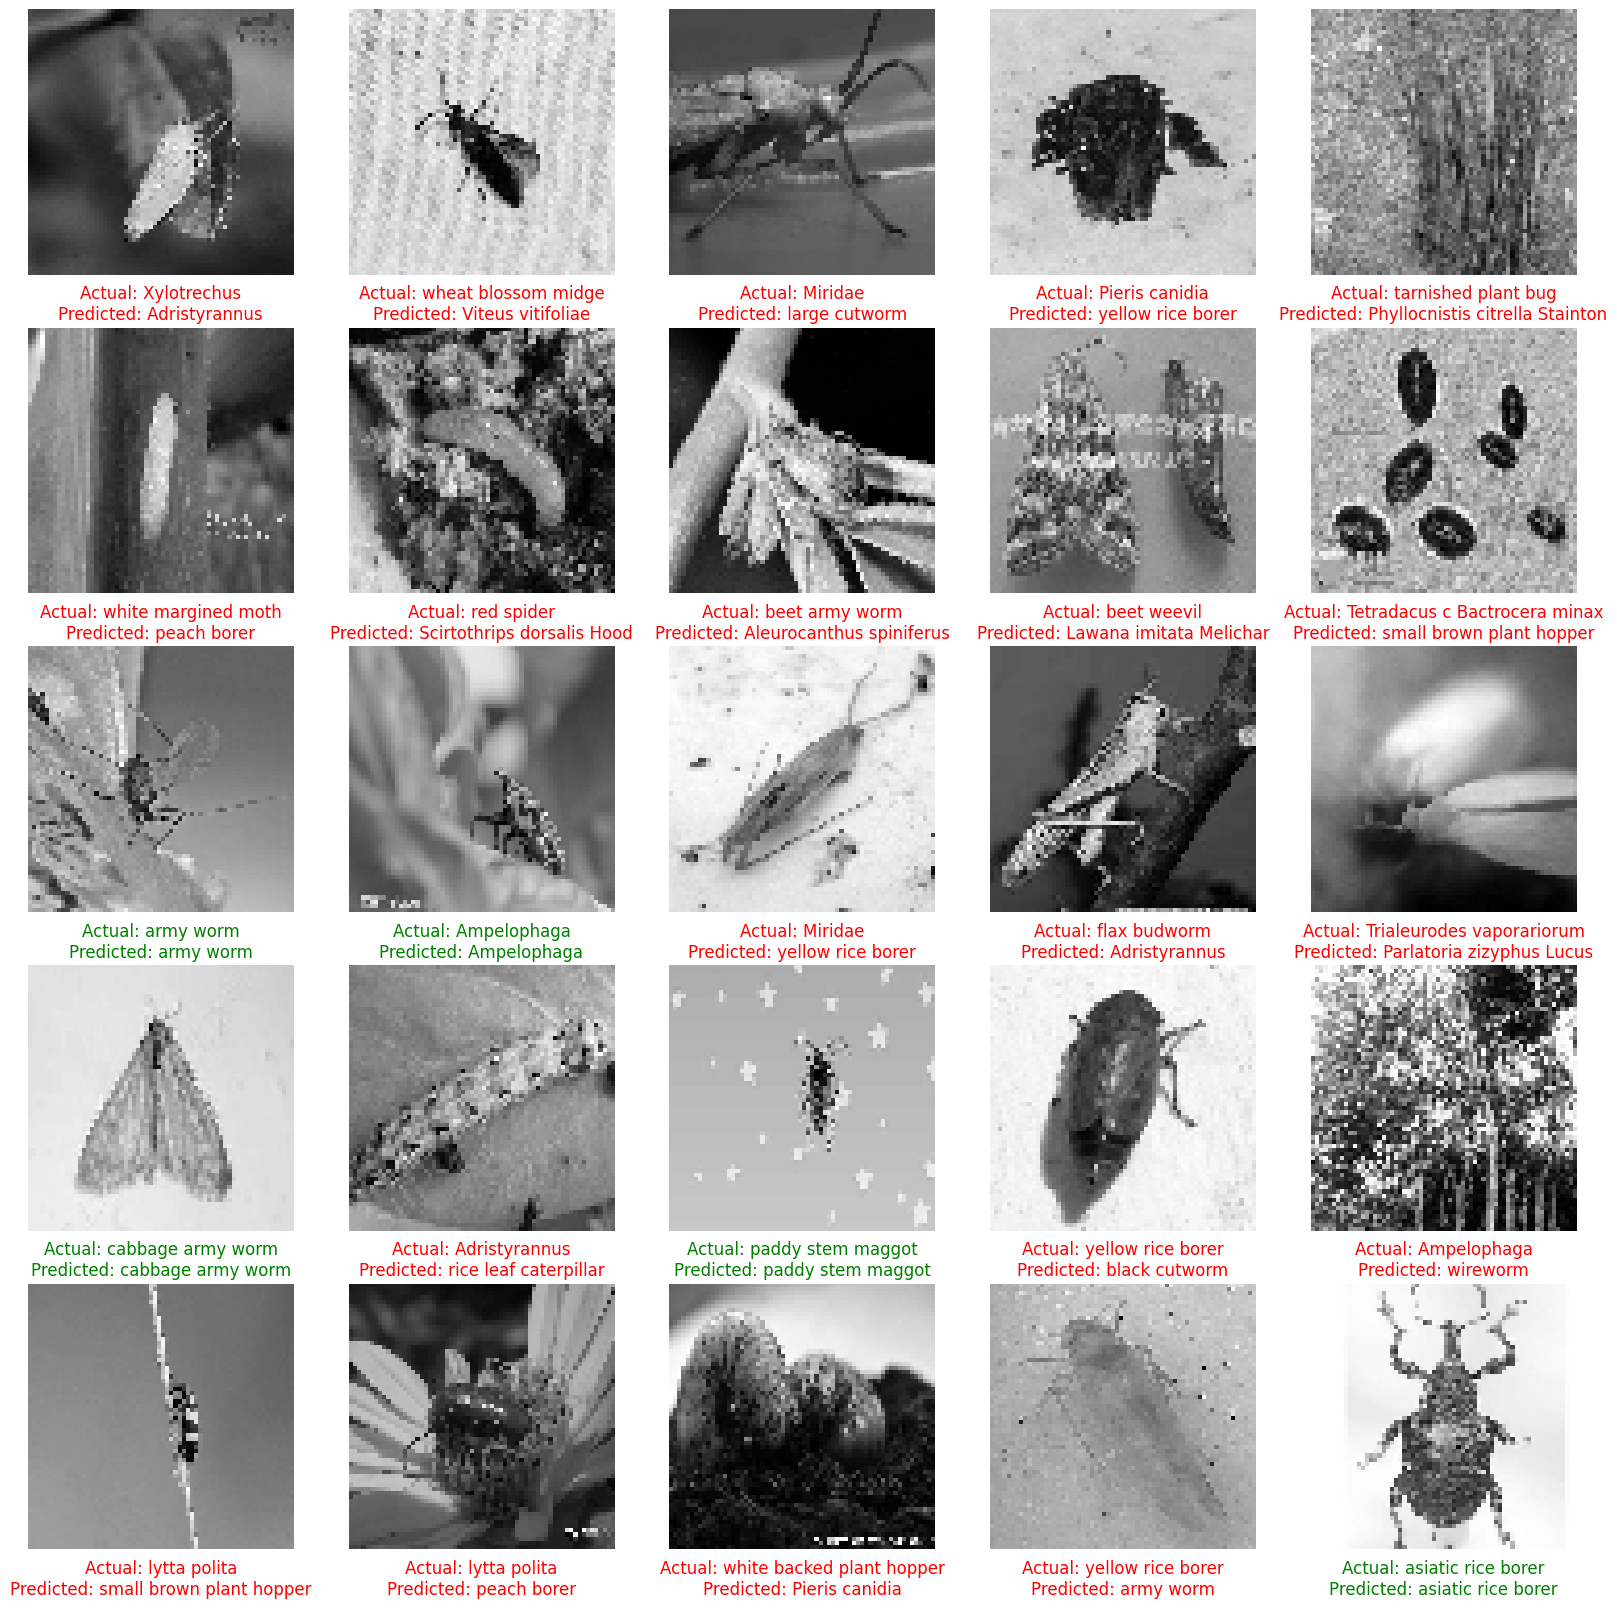

In [ ]:
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

np.random.seed(77)
label_to_name = dict(zip(classes['label'], classes['name']))
num_samples = 25
# Create a new generator just for capturing a few test images
datagen_test = ImageDataGenerator(rescale=1./255)
test_generator = datagen_test.flow_from_directory(test_dir, target_size=(64, 64), batch_size=num_samples, class_mode='sparse', color_mode='grayscale')

# Get class names
class_names = list(test_generator.class_indices.keys())

# Capture one batch of test images and their labels
test_images, test_labels = next(test_generator)

# Use your trained classifier to predict labels for these images
hog_features = np.array([extract_hog_features(img) for img in test_images])
pred_labels = knn.predict(hog_features)

# Plot these test images with their true and predicted labels
fig, axs = plt.subplots(5, 5, figsize=(20, 20))

for i in range(num_samples):
    ax = axs.ravel()[i]
    ax.imshow(test_images[i].reshape(64, 64), cmap='gray')  # Grayscale image
    title = f"Actual: {label_to_name[int(test_labels[i])]}"
    title += f'\nPredicted: {label_to_name[int(pred_labels[i])]}'
    color = 'g' if test_labels[i] == pred_labels[i] else 'r'
    ax.set_title(title, y=-0.20, color=color)
    ax.axis('off')

plt.show()

Found 22619 images belonging to 102 classes.


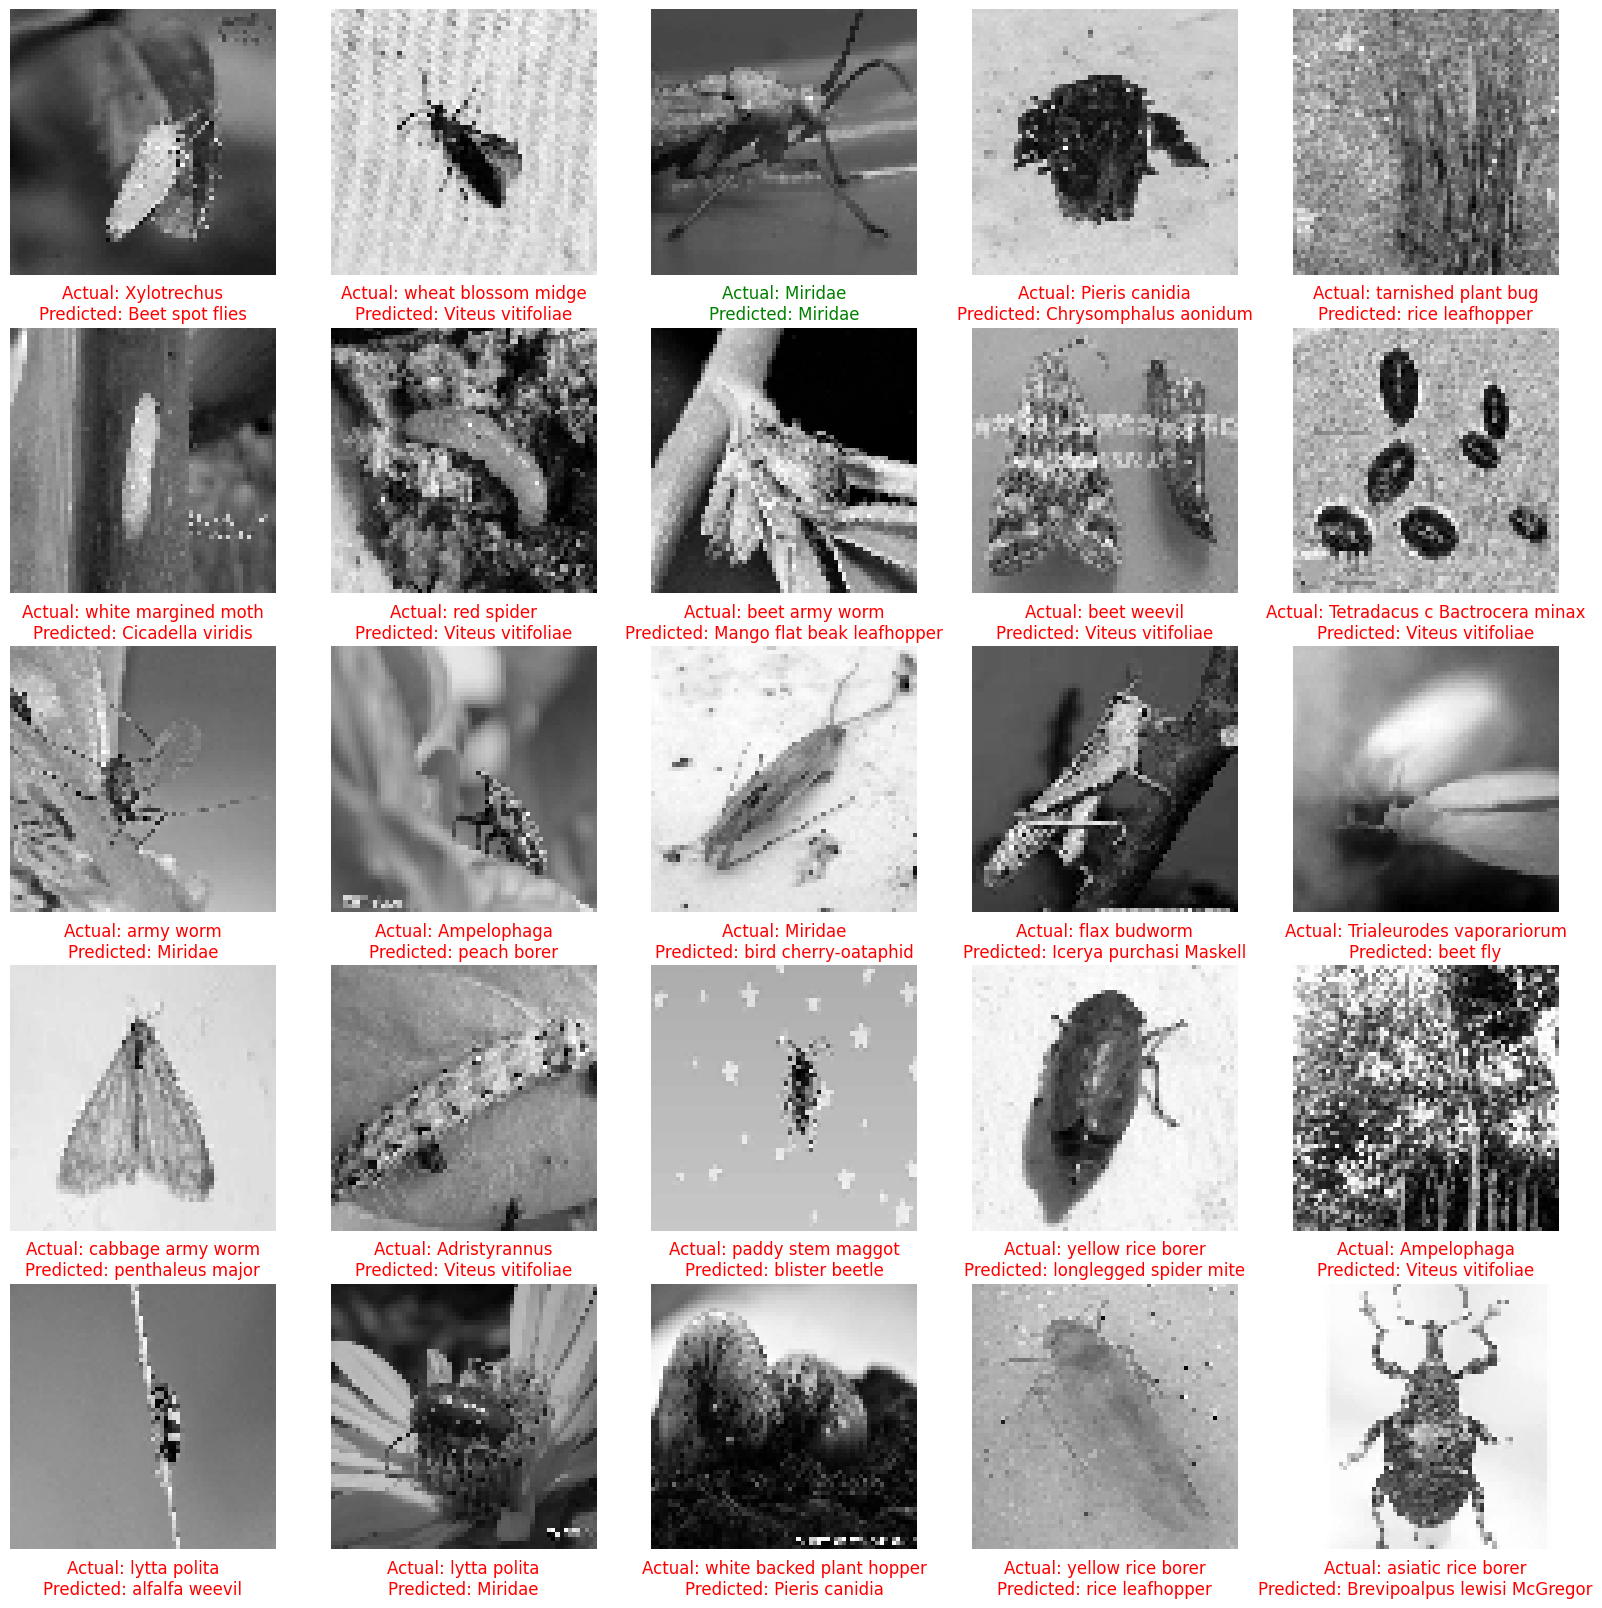

In [ ]:
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

np.random.seed(77)
label_to_name = dict(zip(classes['label'], classes['name']))
num_samples = 25
# Create a new generator just for capturing a few test images
datagen_test = ImageDataGenerator(rescale=1./255)
test_generator = datagen_test.flow_from_directory(test_dir, target_size=(64, 64), batch_size=num_samples, class_mode='sparse', color_mode='grayscale')

# Get class names
class_names = list(test_generator.class_indices.keys())

# Capture one batch of test images and their labels
test_images, test_labels = next(test_generator)

# Use your trained classifier to predict labels for these images
hog_features = np.array([extract_hog_features(img) for img in test_images])
pred_labels = nb.predict(hog_features)

# Plot these test images with their true and predicted labels
fig, axs = plt.subplots(5, 5, figsize=(20, 20))

for i in range(num_samples):
    ax = axs.ravel()[i]
    ax.imshow(test_images[i].reshape(64, 64), cmap='gray')  # Grayscale image
    title = f"Actual: {label_to_name[int(test_labels[i])]}"
    title += f'\nPredicted: {label_to_name[int(pred_labels[i])]}'
    color = 'g' if test_labels[i] == pred_labels[i] else 'r'
    ax.set_title(title, y=-0.20, color=color)
    ax.axis('off')

plt.show()

In [ ]:
import numpy as np
from scipy.stats import wilcoxon

# F1 scores for class 61, 73, 54 and 83
alexnet = np.array([0.864198, 0.875969, 0.822300, 0.827103])
googlenet = np.array([0.870968, 0.913858, 0.887324, 0.838710])
resnet = np.array([0.939024, 0.879433, 0.904943, 0.861314])
vggnet = np.array([0.875000, 0.887273, 0.914286, 0.875912])
knn_w = np.array([0.277108, 0.042373, 0.082051, 0.339785])


# List of model pairs to compare
pairs = [
    ("AlexNet", "GoogLeNet", alexnet, googlenet),
    ("AlexNet", "ResNet", alexnet, resnet),
    ("AlexNet", "VGGNet", alexnet, vggnet),
    ("GoogLeNet", "ResNet", googlenet, resnet),
    ("GoogLeNet", "VGGNet", googlenet, vggnet),
    ("ResNet", "VGGNet", resnet, vggnet),
    ("ResNet", "KNN", resnet, knn_w),
    ("AlexNet", "KNN", alexnet, knn_w),
    ("VGGNet", "KNN", vggnet, knn_w),
    ("GoogLeNet", "KNN", googlenet, knn_w)
]

# Perform Wilcoxon Signed Ranks Test for each pair
for pair in pairs:
    model1, model2, scores1, scores2 = pair
    stat, p_value = wilcoxon(scores1, scores2)
    print(f"Comparison between {model1} and {model2}:")
    print(f"  W-statistic: {stat}, P-value: {p_value}")
    print("----------------------------------------")

Comparison between AlexNet and GoogLeNet:
  W-statistic: 0.0, P-value: 0.125
----------------------------------------
Comparison between AlexNet and ResNet:
  W-statistic: 0.0, P-value: 0.125
----------------------------------------
Comparison between AlexNet and VGGNet:
  W-statistic: 0.0, P-value: 0.125
----------------------------------------
Comparison between GoogLeNet and ResNet:
  W-statistic: 3.0, P-value: 0.625
----------------------------------------
Comparison between GoogLeNet and VGGNet:
  W-statistic: 2.0, P-value: 0.375
----------------------------------------
Comparison between ResNet and VGGNet:
  W-statistic: 4.0, P-value: 0.875
----------------------------------------
Comparison between ResNet and KNN:
  W-statistic: 0.0, P-value: 0.125
----------------------------------------
Comparison between AlexNet and KNN:
  W-statistic: 0.0, P-value: 0.125
----------------------------------------
Comparison between VGGNet and KNN:
  W-statistic: 0.0, P-value: 0.125
-----------